# Logistic Regression and Regularization

In [38]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# regularization makes coefficiets smaller to prevent overfitting
# smaller c means more regularization
# larger c means less regularization
# more regularization less training accuracy but better test accuracy (overfit less)
# L1 = lasso makes coefficents down to 0 good for removing parameters
# L2 = ridge regression  doesnt make coeffiecents go down to 0

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
print(digits.keys())


(1797, 64)
dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [11]:
# assign predictors and dependent to x and y and make dataframe
X = digits.data
y = digits.target
# stratified sampling keeps the balance of classes (predictors and dependents=) for classifiers 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=21, stratify = y)

In [ ]:
# Train and validaton errors initialized as empty list
train_errs = list()
valid_errs = list()

# Loop over values of C_value
for C_value in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    # Create LogisticRegression object and fit
    lr = LogisticRegression(C=C_value)
    lr.fit(X_train, y_train)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - lr.score(X_train, y_train) )
    valid_errs.append( 1.0 - lr.score(X_test, y_test) )
    
# Plot results
plt.semilogx(C_value, train_errs, C_value, valid_errs)
plt.legend(("train", "validation"))
plt.show()

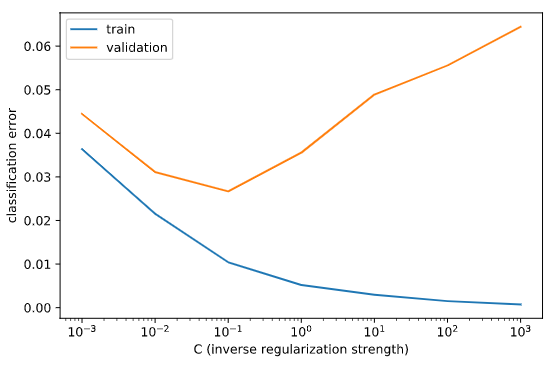

In [29]:
# Specify L2 regularization
lr = LogisticRegression(penalty='l2')

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Best CV params {'C': 0.01}
Total number of features: 640
Number of selected features: 590


In [ ]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional
    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, proba=False, transformation=None, **params):
    """Plot the decision boundaries for a classifier.
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """

    X = np.c_[xx.ravel(), yy.ravel()]
    if transformation is not None:
        X = transformation(X)
        # xx = np.reshape(X[:,0], xx.shape)
        # yy = np.reshape(X[:,1], yy.shape)


    if proba:
        if hasattr(clf, 'predict_proba'):
            Z = clf.predict_proba(X)[:,-1]
            Z = Z.reshape(xx.shape)
            out = ax.imshow(Z,extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)), origin='lower', vmin=0, vmax=1, **params)
            ax.contour(xx, yy, Z, levels=[0.5])
        else:
            Z = clf.decision_function(X)
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, **params)
    else:
        Z = clf.predict(X)
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
    return out

# adapted from http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def plot_classifier(X, y, clf, ax=None, ticks=False, proba=False, transformation=None): # assumes classifier "clf" is already fit
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    if ax is None:
        plt.figure()
        ax = plt.gca()
        show = True
    else:
        show = False

    # can abstract some of this into a higher-level function for learners to call
    plot_contours(ax, clf, xx, yy, proba=proba, transformation=transformation, cmap=plt.cm.coolwarm, alpha=0.8)
    #ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k', linewidth=1)
    labels = np.unique(y)
    if len(labels) == 2:
        ax.scatter(X0[y==labels[0]], X1[y==labels[0]], cmap=plt.cm.coolwarm, s=60, c='b', marker='o', edgecolors='k')
        ax.scatter(X0[y==labels[1]], X1[y==labels[1]], cmap=plt.cm.coolwarm, s=60, c='r', marker='^', edgecolors='k')
    else:
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k', linewidth=1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
#     ax.set_xlabel(data.feature_names[0])
#     ax.set_ylabel(data.feature_names[1])
    if ticks:
        ax.set_xticks(())
        ax.set_yticks(())
#     ax.set_title(title)
    if show:
        plt.show()
    else:
        return ax

def plot_4_classifiers(X, y, clfs):

    # Set-up 2x2 grid for plotting.
    fig, sub = plt.subplots(2, 2)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    for clf, ax, title in zip(clfs, sub.flatten(), ("(1)", "(2)", "(3)", "(4)")):
        # clf.fit(X, y)
        plot_classifier(X, y, clf, ax, ticks=True)
        ax.set_title(title)
    plt.show()



def plot_loss_diagram(labels_inside=False):
    grid = np.linspace(-2,2,1000)
    plt.figure()
    plt.xlabel('$y_iw^T x_i$', fontsize=18)
    # plt.xlabel('raw model output')
    plt.ylabel('$f_i(w)$', fontsize=18)
    plt.xlim(-2,2)
    plt.ylim(-0.025,3)
    plt.fill_between([0, 2], -1, 3, facecolor='blue', alpha=0.2);
    plt.fill_between([-2, 0], -1, 3, facecolor='red', alpha=0.2);
    plt.yticks([0,1,2,3]);

    if labels_inside:
        plt.text(-1.95, 2.73, "incorrect prediction", fontsize=15) # 2.68
        plt.text(0.15, 2.73, "correct prediction", fontsize=15)
    else:
        plt.text(-1.95, 3.1, "incorrect prediction", fontsize=15) # 2.68
        plt.text(0.15, 3.1, "correct prediction", fontsize=15)


    plt.tight_layout()

In [ ]:
# Set the regularization strength
model = LogisticRegression(C=1)

# Fit and plot
model.fit(X,y)
plot_classifier(X,y,model,proba=True)

# Predict probabilities on training points
prob = model.predict_proba(X)
print("Maximum predicted probability", np.max(prob))

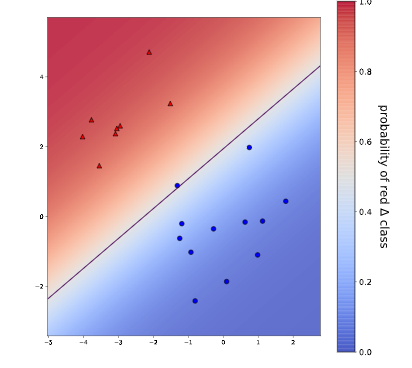

In [46]:
lr = LogisticRegression()
lr.fit(X,y)

# Get predicted probabilities
proba = lr.predict_proba(X)

# Sort the example indices by their maximum probability
proba_inds = np.argsort(np.max(proba,axis=1))
print(proba)

# Show the most confident (least ambiguous) digit
show_digit(proba_inds[-1], lr)

# Show the least confident (most ambiguous) digit
show_digit(proba_inds[0], lr)


[[1.00000000e+00 8.63321093e-22 8.81082472e-16 ... 1.98588534e-12
  2.45173382e-12 9.68034434e-13]
 [2.44596440e-20 9.99999558e-01 5.69083290e-11 ... 1.91410812e-12
  1.09123768e-07 4.43068228e-12]
 [1.35870920e-14 5.77007465e-04 9.99418730e-01 ... 5.34790560e-12
  4.25275689e-06 8.90522466e-16]
 ...
 [2.23425978e-13 1.46984951e-07 4.94171106e-12 ... 4.14784196e-13
  9.99906406e-01 2.85236185e-13]
 [3.79562493e-07 1.11124235e-11 7.34261874e-16 ... 1.44406988e-11
  1.03860158e-06 9.99998582e-01]
 [5.68155543e-12 4.74446731e-09 4.45766143e-12 ... 1.75000458e-14
  9.99977864e-01 2.46031960e-07]]


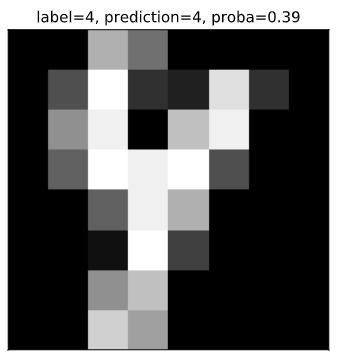

# MULTICLASS LOGISTIC REGRESSION

In [47]:
# Fit one-vs-rest logistic regression classifier
lr_ovr = LogisticRegression()
lr_ovr.fit(X_train, y_train)

print("OVR training accuracy:", lr_ovr.score(X_train, y_train))
print("OVR test accuracy    :", lr_ovr.score(X_test, y_test))

# Fit softmax classifier
lr_mn = LogisticRegression(multi_class="multinomial", solver="lbfgs")
lr_mn.fit(X_train, y_train)

print("Softmax training accuracy:", lr_mn.score(X_train, y_train))
print("Softmax test accuracy    :", lr_mn.score(X_test, y_test))

OVR training accuracy: 1.0
OVR test accuracy    : 0.9648148148148148
Softmax training accuracy: 1.0
Softmax test accuracy    : 0.9648148148148148


In [ ]:
# Print training accuracies
print("Softmax     training accuracy:", lr_mn.score(X_train, y_train))
print("One-vs-rest training accuracy:", lr_ovr.score(X_train, y_train))

# Create the binary classifier (class 1 vs. rest)
lr_class_1 = LogisticRegression(C=100)
lr_class_1.fit(X_train, y_train==1)

# Plot the binary classifier (class 1 vs. rest)
plot_classifier(X_train, y_train==1, lr_class_1)

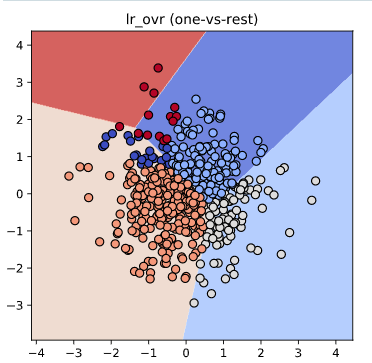

In [ ]:
# We'll use SVC instead of LinearSVC from now on
from sklearn.svm import SVC

# Create/plot the binary classifier (class 1 vs. rest)
svm_class_1 = SVC()
svm_class_1.fit(X_train, y_train==1)
plot_classifier(X_train, y_train==1, svm_class_1)

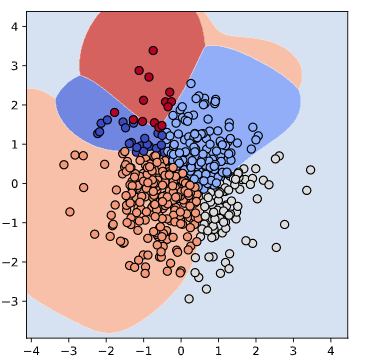